In [1]:
using MAT
using Plots
using Images

include("./unmixing.jl");

In [2]:
pyplot()
filename = "../project_data.mat"
file = matopen(filename)
img = read(file, "im")
sources = read(file,"sources")
rgb = read(file,"rgb")
close(file)

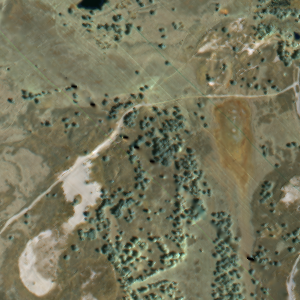

In [3]:
# visualize data in rgb (using bands 67,109,141 as th RGB channels)
p1 = colorview(RGB, permutedims(rgb,(3,1,2))) # convert 3d array to the image format used by julia

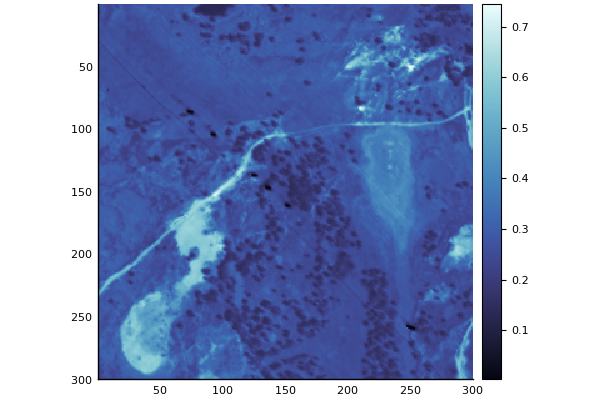

In [4]:
#visualize a spectral band on its own
p2 = heatmap(img[:,:,150],aspect_ratio=1, yflip = true,c=:ice)

In [3]:
# visualize the endmembers to be used

plot(sources[:,1],label = "gravel")
plot!(sources[:,2],label = "grass")
plot!(sources[:,3],label = "soil")
plot!(sources[:,4],label = "trees")
xlabel!("Spectral band")
ylabel!("Reflectance value")

LoadError: InterruptException:

## Unmixing the image

The model we are using to decompose the image into the sum of the contributions of the endmembers is:

\begin{equation*}
\mathbf{X} = \mathbf{S}\mathbf{A} + \mathbf{E} 
\end{equation*}

 $\mathbf{X}\in \mathbb{R}^{L\times N}$ : data matrix
 
 $\mathbf{S}\in \mathbb{R}^{L\times P}$ : endmember matrix
 
 $\mathbf{A}\in \mathbb{R}^{P\times N}$ : abundance matrix
 
 $\mathbf{E}\in \mathbb{R}^{L\times N}$ : additive noise matrix
 
 where $L$ is the number of spectral bands, $P$ is the number of materials, and $N$ is the number of pixels
 
 The hyperspectral image is represented as a matrix with $N$ pixels, so the first thing to do is to reshape the image to a big matrix.

We can try and estimate the abundance matrix using a least squares formulation:

\begin{equation*}
\hat{A} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2}||\mathbf{X}-\mathbf{SA}||_{F}^{2} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2} \sum_{i=1}^{N} ||\mathbf{x}_{n}-\mathbf{S}\mathbf{a}_{n}||_{2}^{2}
\end{equation*}

where $\mathbf{1}_{.}$ is a vector of ones whose size is given in index 

Choose an algorithm to solve the optimization problem, and implement it both in a serial version and a version parallelized across the pixels.

In [5]:
n = 3^2
p = 4
l = 255
k = floor(Int, sqrt(n))

# Use a small crop of the image first
offset_x = 150
offset_y = 1
img_small = img[offset_x:offset_x + k - 1,offset_y:offset_y + k - 1, :]

X = img_small
S = sources;

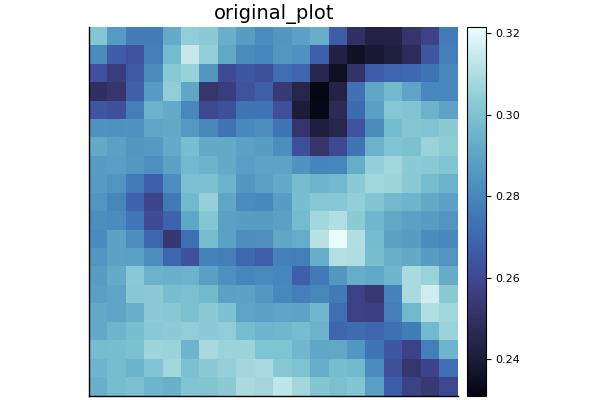

In [7]:
original_plot = heatmap(
    img_small[:, :, 150], title="original_plot", aspect_ratio=1, yflip = true, c=:ice, grid=false, ticks=false
)

# Projected Gradient (single constraint)

In [8]:
new_X_1c, A_1c, mean_loss_1c = estimate_abundance_pixel(X, S, "projected_gradient_1c");

In [9]:
n_pixels, time_1c = get_runtime_series(X, S, "projected_gradient_1c", "serial_pixel");

In [10]:
pg_1c_plot = heatmap(
    new_X_1c[:, :, 150], title="projected_gradient_1c", 
    aspect_ratio=1, yflip = true, c=:ice, grid=false, ticks=false
);

# Projected Gradient (two constraints)

In [11]:
new_X_2c, A_2c, mean_loss_2c = estimate_abundance_pixel(X, S, "projected_gradient_2c");

In [12]:
n_pixels, time_2c = get_runtime_series(X, S, "projected_gradient_2c", "serial_pixel");

In [13]:
pg_2c_plot = heatmap(
    new_X_2c[:, :, 150], title="projected_gradient_2c", 
    aspect_ratio=1, yflip = true, c=:ice, grid=false, ticks=false
);

# Log-barrier method

In [14]:
new_X_lb, A_lb, mean_loss_lb = estimate_abundance_pixel(X, S, "log_barrier");

In [15]:
n_pixels, time_lb = get_runtime_series(X, S, "log_barrier", "serial_pixel");

In [16]:
lb_plot = heatmap(
    new_X_lb[:, :, 150], title="log_barrier", 
    aspect_ratio=1, yflip = true,c=:ice, grid=false, ticks=false
);

# Interior Point Least Square (image-based)

In [ ]:
include("./unmixing.jl");
new_X_ipls, A_ipls, loss_ipls = estimate_abundance_image(X, S, "ipls");

In [ ]:
A_ipls

In [18]:
n_pixels, time_ipls = get_runtime_series(X, S, "ipls", "serial_image", n);

In [19]:
ipls_plot = heatmap(
    new_X_ipls[:, :, 150], title="ipls", 
    aspect_ratio=1, yflip = true,c=:ice, grid=false, ticks=false
);

# Model Comparison

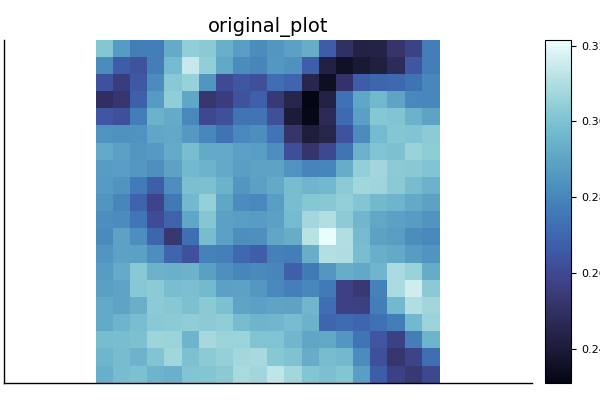

In [20]:
plot(original_plot)

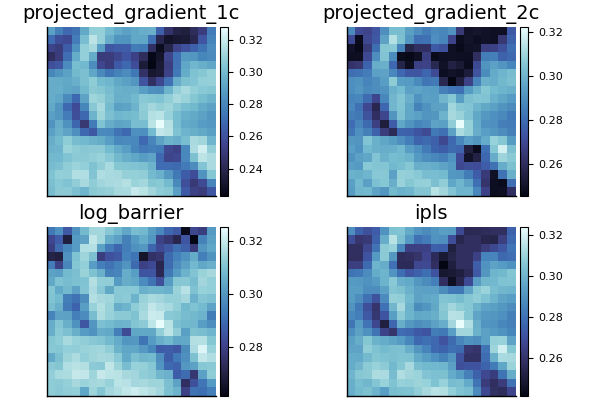

In [21]:
p = plot(pg_1c_plot, pg_2c_plot, lb_plot, ipls_plot, layout=(2, 2))

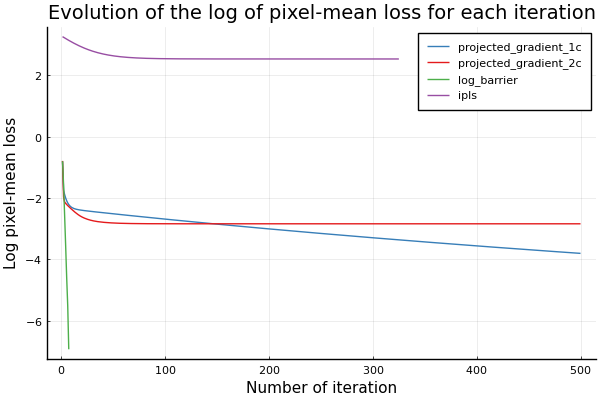

In [22]:
plot(
    log.(mean_loss_1c[mean_loss_1c .> 0]),
    title="Evolution of the log of pixel-mean loss for each iteration",
    ylabel = "Log pixel-mean loss", 
    xlabel = "Number of iteration", 
    label="projected_gradient_1c",
    color="#377eb8"
    
)
plot!(
    log.(mean_loss_2c[mean_loss_2c .> 0]),
    label="projected_gradient_2c",
    color="#e41a1c"
)
plot!(
    log.(mean_loss_lb[mean_loss_lb .> 0]),
    label="log_barrier",
    color="#4daf4a"
)
plot!(
    log.(loss_ipls[loss_ipls .> 0]),
    label="ipls",
    color="#984ea3"
)

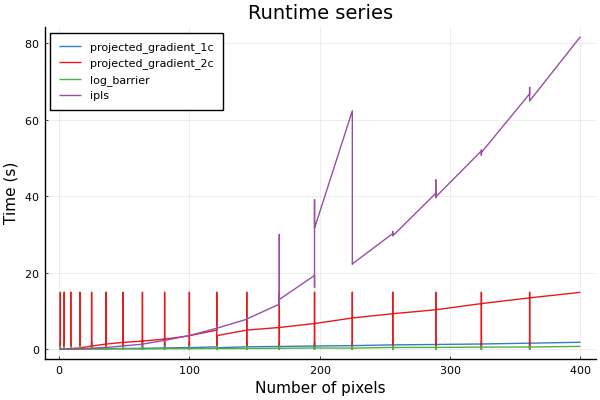

In [23]:
n_pixels2 = [k^2 for k = n_pixels]
plot(
    n_pixels2, time_1c,
    title="Runtime series",
    ylabel = "Time (s)", 
    xlabel = "Number of pixels", 
    label="projected_gradient_1c",
    color="#377eb8"
    
)
plot!(
    n_pixels2, time_2c,
    label="projected_gradient_2c",
    color="#e41a1c"
)
plot!(
    n_pixels2, time_lb,
    label="log_barrier",
    color="#4daf4a"
)
plot!(
    n_pixels2, time_ipls,
    label="ipls",
    color="#984ea3"
)